In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [9]:
import gdown
import os

file_id = "12Gb_fwzUVRAK81mZ2k0YkbTj80gBrV73"
out_path = "vp_cfg_attn8_4_ema_weights.pth"

if not os.path.exists(out_path):
    gdown.download(
        f"https://drive.google.com/uc?id={file_id}",
        out_path,
        quiet=False,
    )
else:
    print("EMA weights already downloaded.")


Downloading...
From (original): https://drive.google.com/uc?id=12Gb_fwzUVRAK81mZ2k0YkbTj80gBrV73
From (redirected): https://drive.google.com/uc?id=12Gb_fwzUVRAK81mZ2k0YkbTj80gBrV73&confirm=t&uuid=e38e1b69-c879-45ed-8f4d-55184682ba8a
To: /home/onyxia/work/vp_cfg_attn8_4_ema_weights.pth
100%|██████████| 158M/158M [00:01<00:00, 107MB/s]  


In [3]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"


In [4]:
class VPSDE:
    def __init__(self, beta_min=0.1, beta_max=20.0, T=1.0):
        self.beta_min = float(beta_min)
        self.beta_max = float(beta_max)
        self.T = float(T)

    def beta(self, t):
        return self.beta_min + t * (self.beta_max - self.beta_min)

    def int_beta(self, t):
        return self.beta_min * t + 0.5 * (self.beta_max - self.beta_min) * t**2

    def alpha(self, t):
        return torch.exp(-0.5 * self.int_beta(t))

    def sigma(self, t):
        a = self.alpha(t)
        return torch.sqrt((1.0 - a*a).clamp(min=1e-12))

    def drift(self, x, t):
        b = self.beta(t).view(-1, 1, 1, 1)
        return -0.5 * b * x


In [5]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim=32):
        super().__init__()
        self.dim = dim
        self.lin = nn.Linear(dim, dim)

    def forward(self, t):
        half_dim = self.dim // 2
        freqs = torch.exp(
            torch.arange(half_dim, device=t.device, dtype=t.dtype)
            * -(torch.log(torch.tensor(10000.0, device=t.device, dtype=t.dtype)) / half_dim)
        )
        args = t[:, None] * freqs[None, :]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        if emb.shape[1] != self.dim:
            emb = F.pad(emb, (0, self.dim - emb.shape[1]))
        return self.lin(emb)


class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, groups=32):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(groups, out_ch),
            nn.SiLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(groups, out_ch),
            nn.SiLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class SelfAttention2d(nn.Module):
    def __init__(self, channels, num_heads=4, gn_groups=32):
        super().__init__()
        assert channels % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = channels // num_heads
        self.scale = self.head_dim ** -0.5

        self.norm = nn.GroupNorm(gn_groups, channels)
        self.qkv = nn.Conv2d(channels, 3 * channels, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        qkv = self.qkv(h)
        q, k, v = qkv.chunk(3, dim=1)

        N = H * W
        q = q.view(B, self.num_heads, self.head_dim, N).permute(0, 1, 3, 2)  # [B,h,N,d]
        k = k.view(B, self.num_heads, self.head_dim, N)                      # [B,h,d,N]
        v = v.view(B, self.num_heads, self.head_dim, N).permute(0, 1, 3, 2)  # [B,h,N,d]

        attn = (q @ k) * self.scale
        attn = attn.softmax(dim=-1)

        out = attn @ v
        out = out.permute(0, 1, 3, 2).contiguous().view(B, C, H, W)
        out = self.proj(out)
        return x + out


class UNetCIFAR3Level_Attn_CFG(nn.Module):
    """
    eps-prediction U-Net with attention at 8x8 and 4x4, plus CFG conditioning.
    y in {0..9} or y=null_label (=10) for unconditional.
    """
    def __init__(self, time_dim=32, base_channels=128, img_channels=3, num_classes=10, attn_heads=4):
        super().__init__()
        self.time_dim = time_dim
        self.num_classes = num_classes
        self.null_label = num_classes

        self.time_mlp = TimeEmbedding(dim=time_dim)
        self.label_emb = nn.Embedding(num_classes + 1, time_dim)

        in_ch = img_channels + time_dim
        C = base_channels

        # Encoder
        self.down1 = ConvBlock(in_ch, C)        # 32x32
        self.pool1 = nn.MaxPool2d(2)            # 32->16

        self.down2 = ConvBlock(C, 2*C)          # 16x16
        self.pool2 = nn.MaxPool2d(2)            # 16->8

        self.down3 = ConvBlock(2*C, 4*C)        # 8x8
        self.attn8 = SelfAttention2d(4*C, num_heads=attn_heads)
        self.pool3 = nn.MaxPool2d(2)            # 8->4

        # Bottleneck
        self.bottleneck = ConvBlock(4*C, 8*C)   # 4x4
        self.attn4 = SelfAttention2d(8*C, num_heads=attn_heads)

        # Decoder
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(8*C, 4*C, 3, padding=1),
        )
        self.dec3 = ConvBlock(8*C, 4*C)

        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(4*C, 2*C, 3, padding=1),
        )
        self.dec2 = ConvBlock(4*C, 2*C)

        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(2*C, C, 3, padding=1),
        )
        self.dec1 = ConvBlock(2*C, C)

        self.out_conv = nn.Conv2d(C, img_channels, 3, padding=1)

    def forward(self, x, t, y=None):
        B, _, H, W = x.shape

        emb_t = self.time_mlp(t)  # [B,time_dim]
        if y is None:
            y = torch.full((B,), self.null_label, device=x.device, dtype=torch.long)
        emb_y = self.label_emb(y)

        emb = emb_t + emb_y
        emb = emb[:, :, None, None].expand(-1, -1, H, W)

        x_in = torch.cat([x, emb], dim=1)

        d1 = self.down1(x_in); p1 = self.pool1(d1)
        d2 = self.down2(p1);   p2 = self.pool2(d2)

        d3 = self.down3(p2)
        d3 = self.attn8(d3)
        p3 = self.pool3(d3)

        b = self.bottleneck(p3)
        b = self.attn4(b)

        u3 = self.up3(b); u3 = torch.cat([u3, d3], dim=1); u3 = self.dec3(u3)
        u2 = self.up2(u3); u2 = torch.cat([u2, d2], dim=1); u2 = self.dec2(u2)
        u1 = self.up1(u2); u1 = torch.cat([u1, d1], dim=1); u1 = self.dec1(u1)

        return self.out_conv(u1)


In [6]:
@torch.no_grad()
def sample_prob_flow_heun_eps_cfg_stable(
    model,
    sde,
    y,                       # [B] labels 0..9
    w=4.0,
    num_steps=200,
    device="cuda",
    t_min=1e-4,
    img_size=32,
    img_channels=3,
    null_label=10,
    clamp_x=True,
    clamp_val=2.0,
    guidance_taper="sigma",  # "sigma" or "linear_t" or None
    time_power=2.0,
):
    model.eval()
    B = y.shape[0]
    y = y.to(device).long()
    y_null = torch.full((B,), null_label, device=device, dtype=torch.long)

    # time grid: more points near small t
    u = torch.linspace(0.0, 1.0, num_steps, device=device)
    t_grid = t_min + (1.0 - t_min) * (u ** time_power)
    t_grid = torch.flip(t_grid, dims=[0])  # 1 -> t_min

    x = torch.randn(B, img_channels, img_size, img_size, device=device)

    sigma_max = float(sde.sigma(torch.ones(1, device=device)).item())

    def ode_drift(x, t_scalar: float):
        t = torch.full((B,), float(t_scalar), device=device)

        beta  = sde.beta(t).view(B, 1, 1, 1)
        sigma = sde.sigma(t).view(B, 1, 1, 1).clamp_min(1e-12)

        eps_u = model(x, t, y_null)
        eps_c = model(x, t, y)
        delta = eps_c - eps_u

        if guidance_taper == "sigma":
            w_t = w * (sigma / sigma_max)
        elif guidance_taper == "linear_t":
            w_t = w * t.view(B, 1, 1, 1)
        else:
            w_t = w

        eps = eps_u + w_t * delta

        # probability flow ODE drift for VP SDE:
        # dx/dt = f(x,t) - 0.5 * beta(t) * score
        # score = -eps / sigma
        drift = sde.drift(x, t) - 0.5 * beta * (-eps / sigma)
        return drift

    for i in range(len(t_grid) - 1):
        t0 = t_grid[i].item()
        t1 = t_grid[i + 1].item()
        dt = t1 - t0  # negative

        k1 = ode_drift(x, t0)
        x_pred = x + dt * k1
        k2 = ode_drift(x_pred, t1)

        x = x + 0.5 * dt * (k1 + k2)

        if clamp_x:
            x = x.clamp(-clamp_val, clamp_val)

    return x


@torch.no_grad()
def sample_one_per_class(model, sde, w=4.0, num_steps=200, device="cuda", t_min=1e-4):
    labels = torch.arange(10, device=device)
    samples = sample_prob_flow_heun_eps_cfg_stable(
        model=model, sde=sde, y=labels,
        w=w, num_steps=num_steps, device=device, t_min=t_min,
        img_size=32, img_channels=3, null_label=10,
    )
    return samples, labels


In [7]:
CIFAR10_NAMES = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

def to_01(x):
    return (x.clamp(-1, 1) + 1) * 0.5

def show_class_row(samples, labels=None, title="One sample per class"):
    x = to_01(samples.detach().cpu())
    B = x.size(0)

    plt.figure(figsize=(2*B, 2.5))
    for i in range(B):
        plt.subplot(1, B, i+1)
        img = x[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.axis("off")
        if labels is not None:
            plt.title(CIFAR10_NAMES[int(labels[i])], fontsize=9)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


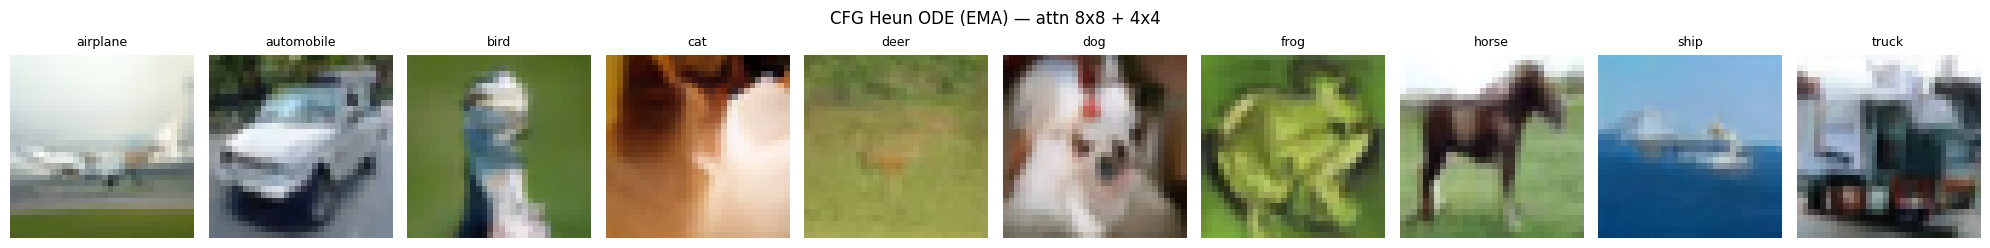

In [10]:
# ---- match training hyperparams from the notebook ----
num_classes = 10
time_dim = 32
base_channels = 128
img_channels = 3
attn_heads = 4

beta_min = 0.1
beta_max = 20.0
T = 1.0
t_min = 1e-4

ema_weights_path = "vp_cfg_attn8_4_ema_weights.pth"  # from the extractor

sde = VPSDE(beta_min=beta_min, beta_max=beta_max, T=T)

ema_model = UNetCIFAR3Level_Attn_CFG(
    time_dim=time_dim,
    base_channels=base_channels,
    img_channels=img_channels,
    num_classes=num_classes,
    attn_heads=attn_heads,
).to(device)

ema_sd = torch.load(ema_weights_path, map_location=device)
ema_model.load_state_dict(ema_sd, strict=True)
ema_model.eval()

samples, labels = sample_one_per_class(
    ema_model, sde,
    w=4.0,
    num_steps=500,
    device=device,
    t_min=t_min,
)

show_class_row(samples, labels, title="CFG Heun ODE (EMA) — attn 8x8 + 4x4")
